In [1]:
import torch
from PIL import Image
from diffusers import AutoencoderKL, UNet2DModel, DDIMPipeline, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
import math
import requests
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)
from accelerate import Accelerator
import utils
from tqdm import tqdm
import torch.nn.functional as F


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
training_config = utils.DiffusionTrainingArgs()

In [3]:
# Load an image of my dog for this example

image_url = "https://i.imgur.com/IJcs4Aa.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw)

In [4]:
# Define the transforms to apply to the image for training
augmentations = utils.get_train_transforms(training_config)

In [5]:
train_image = augmentations(image.convert("RGB"))

In [6]:
model = UNet2DModel.from_pretrained("bglick13/minnie-diffusion")


In [10]:
def distill(teacher, n, train_image, epochs=100, lr=3e-4, batch_size=16):
    accelerator = Accelerator(
    gradient_accumulation_steps=training_config.gradient_accumulation_steps,
    mixed_precision=training_config.mixed_precision,
)
    if accelerator.is_main_process:
        run = "distill"
        accelerator.init_trackers(run)
    teacher_scheduler = DDIMScheduler(num_train_timesteps=n)
    student_scheduler = DDIMScheduler(num_train_timesteps=n // 2)
    student = utils.get_unet(training_config)
    student.load_state_dict(teacher.state_dict())
    student = accelerator.prepare(student)
    student.train()
    optimizer = torch.optim.AdamW(
        student.parameters(),
        lr=lr,
        betas=(training_config.adam_beta1, training_config.adam_beta2),
        weight_decay=0.001,
        eps=training_config.adam_epsilon,
    )
    lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(epochs) // training_config.gradient_accumulation_steps,
)
    teacher, student, optimizer, lr_scheduler, train_image, teacher_scheduler, student_scheduler = accelerator.prepare(
    teacher, student, optimizer, lr_scheduler, train_image,teacher_scheduler, student_scheduler
)
    ema_model = EMAModel(student, inv_gamma=training_config.ema_inv_gamma, power=training_config.ema_power, max_value=training_config.ema_max_decay)
    global_step = 0
    for epoch in range(epochs):
        progress_bar = tqdm(total=1, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        batch = train_image.unsqueeze(0).repeat(
            batch_size, 1, 1, 1
        ).to(accelerator.device)
        with accelerator.accumulate(student):
            noise = torch.randn(batch.shape).to(accelerator.device)
            bsz = batch.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(
                2, student_scheduler.config.num_train_timesteps, (bsz,), device=batch.device
            ).long() * 2
            with torch.no_grad():
                alpha_t, sigma_t = teacher_scheduler.get_alpha_sigma(batch, timesteps, accelerator.device)
                z_t = alpha_t * batch + sigma_t * noise
                alpha_t_prime2, sigma_t_prime2 = teacher_scheduler.get_alpha_sigma(batch, timesteps-2, accelerator.device)
                alpha_t_prime, sigma_t_prime = teacher_scheduler.get_alpha_sigma(batch, timesteps-1, accelerator.device)
                noise_pred_t = teacher(z_t, timesteps).sample
                x_teacher_z_t = (alpha_t * z_t - sigma_t * noise_pred_t).clip(-1, 1)

                z_t_prime = alpha_t_prime * x_teacher_z_t + (sigma_t_prime / sigma_t) * (z_t - alpha_t * x_teacher_z_t)
                noise_pred_t_prime = teacher(z_t_prime.float(), timesteps - 1).sample
                rec_t_prime = (alpha_t_prime * z_t_prime - sigma_t_prime * noise_pred_t_prime).clip(-1, 1)

                x_teacher_z_t_prime = (z_t - alpha_t_prime2 * rec_t_prime) / sigma_t_prime2
                z_t_prime_2 = alpha_t_prime2 * x_teacher_z_t_prime - sigma_t_prime2 * rec_t_prime

            noise_pred = student(z_t, timesteps).sample
            loss = F.mse_loss(noise_pred, z_t_prime_2)
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(student.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            if training_config.use_ema:
                ema_model.step(student)
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        if training_config.use_ema:
            logs["ema_decay"] = ema_model.decay
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
        progress_bar.close()

        accelerator.wait_for_everyone()
    return student, ema_model, accelerator
teacher, distilled_ema, distill_accelrator = distill(model, 1000, train_image, epochs=300, batch_size=64)

Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, ema_decay=0.986, loss=0.0179, lr=0, step=300]


In [11]:
new_scheduler = DDIMScheduler(num_train_timesteps=500)
pipeline = DDIMPipeline(
    unet=distill_accelrator.unwrap_model(distilled_ema.averaged_model if training_config.use_ema else teacher),
    scheduler=new_scheduler,
)

generator = torch.manual_seed(0)
# run pipeline in inference (sample random noise and denoise)
images = pipeline(generator=generator, batch_size=training_config.batch_size, output_type="numpy").images

# denormalize the images and save to tensorboard
images_processed = (images * 255).round().astype("uint8")

  0%|          | 0/50 [00:00<?, ?it/s]

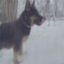

In [12]:
display(Image.fromarray(images_processed[0]))